<a href="https://colab.research.google.com/github/sergekamanzi/Fraud-Detection/blob/main/fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.optimizers import RMSprop
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_score, recall_score, precision_recall_curve
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.losses import binary_crossentropy

In [17]:
# Load Dataset
data = pd.read_csv('/content/frauds_dataset.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,380.0,CASH_OUT,92888.94,C2054348498,27657.00,0.00,C1853199806,5838781.76,5931670.70,0.0,0.0
1,646.0,TRANSFER,399045.08,C724693370,10399045.08,10399045.08,C1909486199,0.00,0.00,1.0,1.0
2,384.0,CASH_IN,35416.73,C1095508813,1154711.52,1190128.25,C961243143,927932.70,892515.97,0.0,0.0
3,518.0,CASH_IN,52211.31,C1867780533,2985.00,55196.31,C1425168473,433652.93,381441.62,0.0,0.0
4,450.0,CASH_OUT,1463764.35,C2142422300,1463764.35,0.00,C1173885211,385211.95,1848976.30,1.0,0.0


In [18]:
# Encode categorical variables
label_encoder = LabelEncoder()
data['type'] = label_encoder.fit_transform(data['type'])
data['nameOrig'] = label_encoder.fit_transform(data['nameOrig'])
data['nameDest'] = label_encoder.fit_transform(data['nameDest'])

# Feature Engineering
data['balance_change_orig'] = data['oldbalanceOrg'] - data['newbalanceOrig']
data['balance_change_dest'] = data['oldbalanceDest'] - data['newbalanceDest']
data['transaction_ratio_orig'] = data['amount'] / (data['oldbalanceOrg'] + 1)
data['transaction_ratio_dest'] = data['amount'] / (data['oldbalanceDest'] + 1)

# Handle missing values
data.fillna(data.median(), inplace=True)

# Drop unnecessary columns
data.drop(columns=['nameDest', 'isFlaggedFraud'], inplace=True)

# Split features and target
X = data.drop(columns=['isFraud'])
Y = data['isFraud']

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [19]:
# Split into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42, stratify=Y_temp)

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=1.0, random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_resampled), y=Y_train_resampled)
class_weights_dict = {0: class_weights[0], 1: class_weights[1] * 3}

#adam and L2

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6625 - loss: 0.9640 - val_accuracy: 0.6093 - val_loss: 0.8579
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8188 - loss: 0.8517 - val_accuracy: 0.4749 - val_loss: 0.8289
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8477 - loss: 0.8053 - val_accuracy: 0.6481 - val_loss: 0.7900
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8676 - loss: 0.7618 - val_accuracy: 0.7900 - val_loss: 0.7443
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8846 - loss: 0.7188 - val_accuracy: 0.8505 - val_loss: 0.6988
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.8911 - loss: 0.6759 - val_accuracy: 0.9035 - val_loss: 0.6518
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8977 - loss: 0.6359 - val_accuracy: 0.8694 - val_loss: 0.6114
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8984 - loss: 0.5972 - val_accuracy: 0.

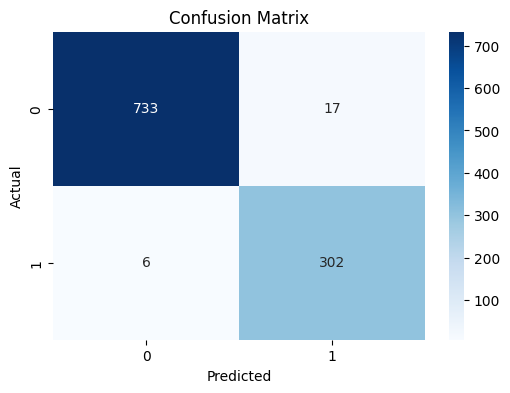

In [20]:
# Custom Focal Loss Function
def focal_loss(alpha=0.75, gamma=3):
    def loss(y_true, y_pred):
        bce = binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_term = alpha * K.pow((1 - p_t), gamma)
        return focal_term * bce
    return loss

# Define the Advanced Neural Network Model with L2 Regularization
inputs = Input(shape=(X_train_resampled.shape[1],))

x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
residual = BatchNormalization()(residual)
residual = Dropout(0.3)(residual)

x = Add()([x, residual])

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile Model
optimizer = Adam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss=focal_loss(alpha=0.75, gamma=3), metrics=['accuracy'])

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model with Early Stopping
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=100, batch_size=256,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping],
                    verbose=1)

# Predict Probabilities
Y_pred_probs = model.predict(X_test)

# Adjust Classification Threshold Using Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_pred_probs)
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]

# Convert Probabilities to Class Labels
Y_pred = (Y_pred_probs > best_threshold).astype("int32")

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


#RMSprop and L1

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.7312 - loss: 14.9387 - val_accuracy: 0.7720 - val_loss: 13.4097
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.8667 - loss: 13.0226 - val_accuracy: 0.8344 - val_loss: 11.8724
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8848 - loss: 11.3629 - val_accuracy: 0.6443 - val_loss: 10.3554
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9018 - loss: 9.6887 - val_accuracy: 0.6812 - val_loss: 8.7625
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9024 - loss: 8.1664 - val_accuracy: 0.8751 - val_loss: 7.2684
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9193 - loss: 6.8176 - val_accuracy: 0.8675 - val_loss: 6.0448
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9255 - loss: 5.6454 - val_accuracy: 0.7720 - val_loss: 5.1089
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9311 - loss: 4.6776 - val_accura

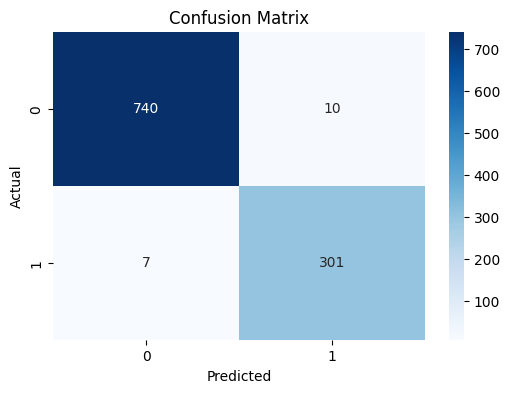

In [8]:
# Define the Advanced Neural Network Model with L1 Regularization
inputs = Input(shape=(X_train_resampled.shape[1],))

x = Dense(512, activation='relu', kernel_regularizer=l1(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = Dense(512, activation='relu', kernel_regularizer=l1(0.001))(x)
residual = BatchNormalization()(residual)
residual = Dropout(0.3)(residual)

x = Add()([x, residual])

x = Dense(128, activation='relu', kernel_regularizer=l1(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l1(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile Model
optimizer = RMSprop(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model with Early Stopping
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=100, batch_size=256,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping],
                    verbose=1)

# Predict Probabilities
Y_pred_probs = model.predict(X_test)

# Convert Probabilities to Class Labels
Y_pred = (Y_pred_probs > 0.5).astype("int32")

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#SDG and l1-l2

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.5847 - loss: 9.0786 - val_accuracy: 0.3586 - val_loss: 8.1960
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7557 - loss: 8.4773 - val_accuracy: 0.3283 - val_loss: 8.2042
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7928 - loss: 8.2689 - val_accuracy: 0.3236 - val_loss: 8.2049
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8156 - loss: 8.1388 - val_accuracy: 0.3264 - val_loss: 8.1880
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8337 - loss: 8.0490 - val_accuracy: 0.3321 - val_loss: 8.1735
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8319 - loss: 7.9802 - val_accuracy: 0.3690 - val_loss: 8.1227
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8547 - loss: 7.8965 - val_accuracy: 0.4428 - val_loss: 8.0855
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.8544 - loss: 7.8463 - val_accuracy: 0.

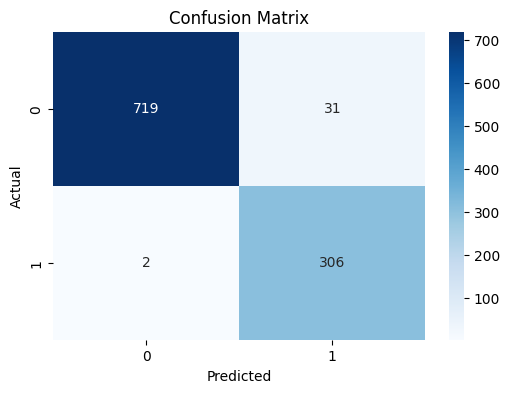

In [9]:
# Define the Advanced Neural Network Model with L1_L2 Regularization
inputs = Input(shape=(X_train_resampled.shape[1],))

x = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = Dense(512, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(x)
residual = BatchNormalization()(residual)
residual = Dropout(0.3)(residual)

x = Add()([x, residual])

x = Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.0005, l2=0.0005))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile Model
optimizer = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model with Early Stopping
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=100, batch_size=256,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping],
                    verbose=1)

# Predict Probabilities
Y_pred_probs = model.predict(X_test)

# Convert Probabilities to Class Labels
Y_pred = (Y_pred_probs > 0.5).astype("int32")

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


#classical Loogistic regression


Best Parameters: {'C': 100, 'solver': 'lbfgs'}
Accuracy: 0.9371
Precision: 0.8912
Recall: 0.8927
F1 Score: 0.8920


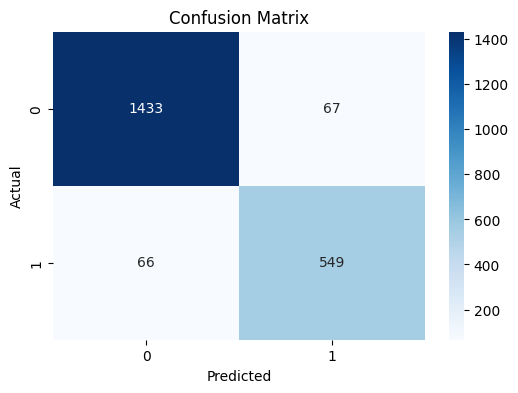

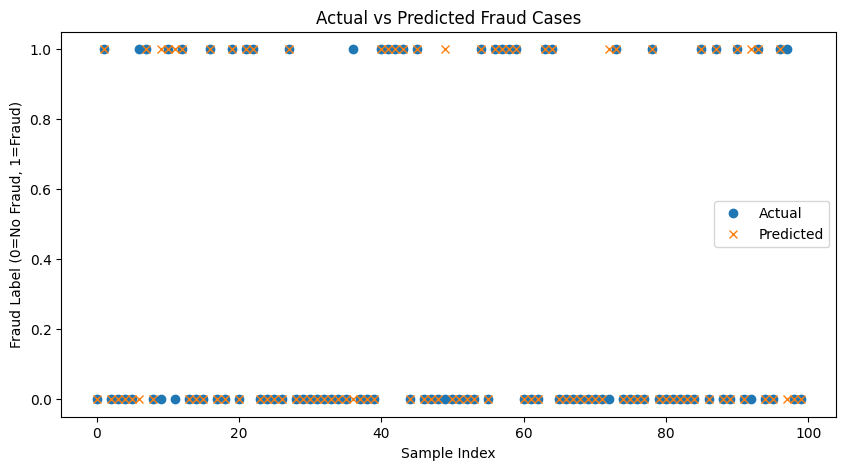

In [10]:
# Feature Selection
selector = SelectKBest(f_classif, k=10)  # Keep 10 best features
X_selected = selector.fit_transform(X_scaled, Y)

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_selected, Y, test_size=0.3, random_state=42, stratify=Y)

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

# Hyperparameter tuning using GridSearchCV
param_grid = {'C': [0.01, 0.1, 1, 10, 100], 'solver': ['liblinear', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(class_weight='balanced', random_state=42), param_grid, cv=5, scoring='f1')
grid_search.fit(X_train_resampled, Y_train_resampled)
best_model = grid_search.best_estimator_

# Make predictions
Y_pred = best_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Print evaluation metrics
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Actual vs Predicted values
plt.figure(figsize=(10,5))
plt.plot(Y_test.values[:100], label="Actual", marker='o', linestyle="")
plt.plot(Y_pred[:100], label="Predicted", marker='x', linestyle="")
plt.xlabel("Sample Index")
plt.ylabel("Fraud Label (0=No Fraud, 1=Fraud)")
plt.title("Actual vs Predicted Fraud Cases")
plt.legend()
plt.show()


#A simple machine learning model without an optimizer

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7921 - loss: 0.4752 - val_accuracy: 0.8733 - val_loss: 0.3394
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8900 - loss: 0.2869 - val_accuracy: 0.9021 - val_loss: 0.2688
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9096 - loss: 0.2249 - val_accuracy: 0.9144 - val_loss: 0.2180
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9284 - loss: 0.1752 - val_accuracy: 0.9329 - val_loss: 0.1687
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9380 - loss: 0.1584 - val_accuracy: 0.9414 - val_loss: 0.1495
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9441 - loss: 0.1335 - val_accuracy: 0.9475 - val_loss: 0.1298
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9541 - loss: 0.1185 - val_accuracy: 0.9461 - val_loss: 0.1372
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9587 - loss: 0.1096 - val_accuracy: 

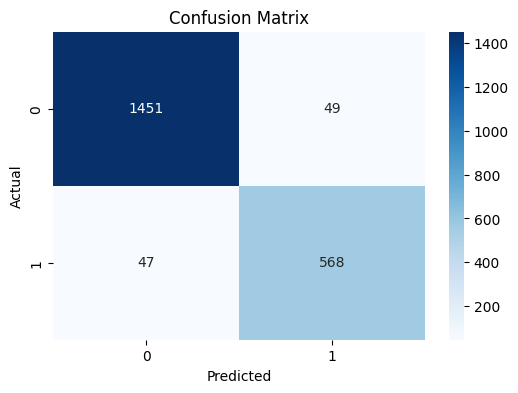

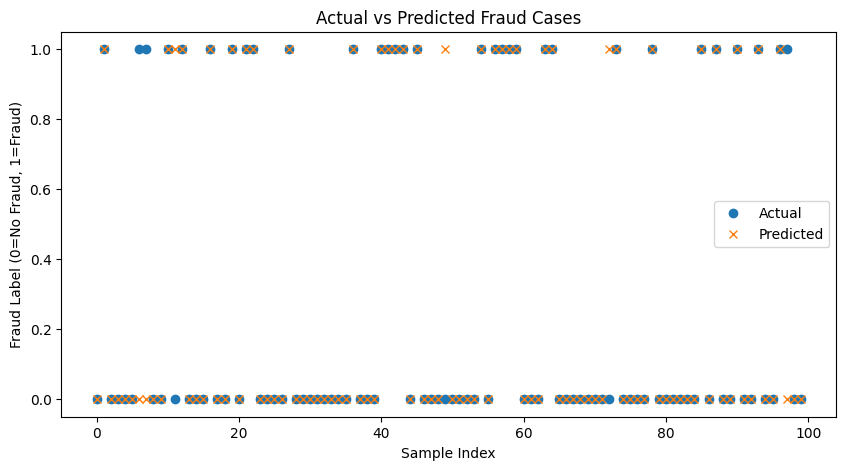

In [13]:
# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=42, stratify=Y)

# Define a simple neural network model without specifying an optimizer
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model without specifying an optimizer
model.compile(loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10, batch_size=32, verbose=1)

# Make predictions
Y_pred_probs = model.predict(X_test)
Y_pred = (Y_pred_probs > 0.5).astype(int)

# Evaluate the model
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Generate Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot Actual vs Predicted values
plt.figure(figsize=(10,5))
plt.plot(Y_test.values[:100], label="Actual", marker='o', linestyle="")
plt.plot(Y_pred[:100], label="Predicted", marker='x', linestyle="")
plt.xlabel("Sample Index")
plt.ylabel("Fraud Label (0=No Fraud, 1=Fraud)")
plt.title("Actual vs Predicted Fraud Cases")
plt.legend()
plt.show()


#Nadam + l2

Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 69ms/step - accuracy: 0.6134 - loss: 1.0161 - val_accuracy: 0.8742 - val_loss: 0.8562
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8047 - loss: 0.8650 - val_accuracy: 0.8732 - val_loss: 0.8288
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8304 - loss: 0.8304 - val_accuracy: 0.8761 - val_loss: 0.7969
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8693 - loss: 0.7889 - val_accuracy: 0.8732 - val_loss: 0.7642
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.8786 - loss: 0.7585 - val_accuracy: 0.8770 - val_loss: 0.7321
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8848 - loss: 0.7214 - val_accuracy: 0.8789 - val_loss: 0.6979
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9012 - loss: 0.6863 - val_accuracy: 0.8770 - val_loss: 0.6657
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8963 - loss: 0.6536 - val_accuracy: 0.

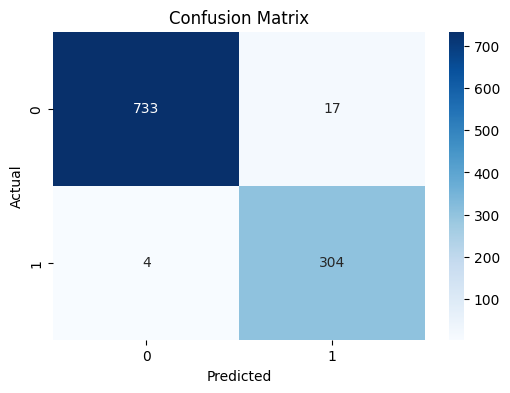

In [21]:
# Custom Focal Loss Function
def focal_loss(alpha=0.75, gamma=3):
    def loss(y_true, y_pred):
        bce = binary_crossentropy(y_true, y_pred)
        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_term = alpha * K.pow((1 - p_t), gamma)
        return focal_term * bce
    return loss

# Define the Advanced Neural Network Model with L2 Regularization
inputs = Input(shape=(X_train_resampled.shape[1],))

x = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)

residual = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
residual = BatchNormalization()(residual)
residual = Dropout(0.3)(residual)

x = Add()([x, residual])

x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)

outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs, outputs)

# Compile Model with Nadam Optimizer
optimizer = Nadam(learning_rate=0.0003)
model.compile(optimizer=optimizer, loss=focal_loss(alpha=0.75, gamma=3), metrics=['accuracy'])

# Define Early Stopping Callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the Model with Early Stopping
history = model.fit(X_train_resampled, Y_train_resampled,
                    validation_data=(X_val, Y_val),
                    epochs=100, batch_size=256,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping],
                    verbose=1)

# Predict Probabilities
Y_pred_probs = model.predict(X_test)

# Adjust Classification Threshold Using Precision-Recall Curve
precisions, recalls, thresholds = precision_recall_curve(Y_test, Y_pred_probs)
best_threshold = thresholds[np.argmax(2 * (precisions * recalls) / (precisions + recalls))]

# Convert Probabilities to Class Labels
Y_pred = (Y_pred_probs > best_threshold).astype("int32")

# Calculate Accuracy, Precision, Recall, and F1 Score
accuracy = accuracy_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
